# A model for predicting basal area increment

Here we will adapt the basic model form for predicting Basal Area Increment (BAI) that was introduced by Wykoff (1990), which is now widely used to predict diameter growth of trees in the Forest Vegetation Simulator. This notebook applies a recursive form of these equations that can simulate growth through multiple timesteps so that predicted BAI can be compared with observed BAI measured across arbitrary periods (in this case, making annual predictions over a span of 10 years).

This notebook illustrates fitting the model across several ecoregions with three approaches to account for variance in model parameters among the ecoregions:
1. Fully pooled - a single set of coefficients are modeled across all ecoregions
2. Unpooled - independent sets of coefficients are modeled for each ecoregion
3. Partially pooled - coefficients across ecoregions are drawn from a shared parent distribution

This model can be fit using Markov Chain Monte Carlo for full Bayesian inference. Due to the number of observations and the complexity of fitting this recursive model, even reparameterized version of the model fit using the No U-Turn Sampler would require very long runtimes. As an alternative, this notebook demonstrates the use of Stochastic Variational Inference (SVI) to fit the models. This optimization approach returns Maximum a Posteriori (MAP) estimates approximating the posterior mode of each model parameter.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from functools import partial

import jax
from jax import numpy as jnp
from jax import random, jit

import numpyro
import numpyro.distributions as dist

from numpyro.infer import MCMC, NUTS, Predictive, Trace_ELBO, SVI, autoguide
from numpyro.infer import init_to_feasible, init_to_median, init_to_uniform, init_to_value
from numpyro.infer.reparam import LocScaleReparam
import arviz as az

from matplotlib import pyplot as plt
from scipy import stats
import matplotlib.patheffects as pe

In [2]:
from refit_fvs.models.diameter_growth import wykoff_model, potential_modified_model

In [3]:
CSV = '../data/interim/FIA_remeasured_trees_for_training.csv'
df = pd.read_csv(CSV)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290429 entries, 0 to 290428
Data columns (total 63 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   STATECD            290429 non-null  int64  
 1   UNITCD             290429 non-null  int64  
 2   COUNTYCD           290429 non-null  int64  
 3   PLOT               290429 non-null  int64  
 4   PLOT_ID            290429 non-null  int64  
 5   SUBPLOT            290429 non-null  int64  
 6   SUBPLOT_ID         290429 non-null  int64  
 7   PLOT_CN            290429 non-null  int64  
 8   PLOT_CN_NEXT       290429 non-null  int64  
 9   TREE_CN            220620 non-null  float64
 10  TREE_CN_NEXT       269952 non-null  float64
 11  TREE_ID            290429 non-null  int64  
 12  LAT                290429 non-null  float64
 13  LON                290429 non-null  float64
 14  ELEV               290429 non-null  float64
 15  VARIANT            290429 non-null  object 
 16  LO

In [4]:
gdf = gpd.read_file('../data/raw/FVS_Variants_and_Locations.shp')
variants = np.unique(df.VARIANT)
locations = np.sort(np.array([*set(np.unique(gdf.loc[gdf.FVSVariant.isin(variants), 'FVSLocCode'])).union(np.unique(df.LOCATION))], dtype='int'))
plots = np.unique(df.PLOT_ID)

In [5]:
df['VAR_IDX'], obs_variants = pd.factorize(df['VARIANT'])
df['LOC_IDX'], obs_locations = pd.factorize(df['LOCATION'])
df['PLOT_IDX'], obs_plots = pd.factorize(df['PLOT_ID'])

We'll extract a subset of the full dataset for model-fitting. In this case, we filter the dataset to Douglas-fir trees (`FIA_SPCD == 202`), to trees that were alive at two subsequent measurement periods, and for trees remeasured on a 10-year interval. This leaves us with ~46,640 trees observed across Washington, California, and Oregon to fit our model to.

In [6]:
wykoff = partial(wykoff_model, num_steps=10, bark_b1=0.903563, bark_b2=0.989388,
                    num_variants=len(variants), num_locations=len(locations), num_plots=len(plots))
wykoff.__name__ = 'wykoff'

potential_modified = partial(potential_modified_model, num_steps=10, bark_b1=0.903563, bark_b2=0.989388,
                    num_variants=len(variants), num_locations=len(locations), num_plots=len(plots)) 
potential_modified.__name__ = 'potential_modified'

In [7]:
RAW_COVARS = ['VAR_IDX', 'LOC_IDX',  'PLOT_IDX', 'SICOND', 'SLOPE', 'ELEV',
              'DBH', 'CR', 'CR_NEXT', 'BAPALARGER', 'BAPALARGER_NEXT', 
              'PTBAPA', 'PTBAPA_NEXT']
RAW_OBS = ['DBH_NEXT']

MODEL_COVARS = ['VAR_IDX', 'LOC_IDX',  'PLOT_IDX', 'SICOND', 'SLOPE', 'ELEV', 
               'DBH', 'CR_START', 'CR_END', 'COMP_TREE_START', 'COMP_TREE_END', 
               'COMP_STAND_START', 'COMP_STAND_END']
MODEL_OBS = ['BAI_OBS']

data = df.loc[(df.FIA_SPCD == 202)&(df.STATUSCD==1)&(df.STATUSCD_NEXT==1)&((df.MEASYEAR_NEXT - df.MEASYEAR) == 10)].dropna(subset=RAW_COVARS)[RAW_COVARS + RAW_OBS].copy()
data[['CR_START', 'CR_END']] = data[['CR', 'CR_NEXT']] / 100.
data['COMP_TREE_START'] = data['BAPALARGER'] / np.log(data['DBH'] + 1.0)
data['COMP_TREE_END'] = data['BAPALARGER_NEXT'] / np.log(data['DBH_NEXT'] + 1.0)
data['COMP_STAND_START'] = np.log(data['PTBAPA'])
data['COMP_STAND_END'] = np.log(data['PTBAPA_NEXT'])
data['SLOPE'] = data['SLOPE'] / 100.
data['ELEV'] = data['ELEV'] / 100.
data['BAI_OBS'] = np.pi/4*(data['DBH_NEXT']**2 - data['DBH']**2)
data['DG_OBS'] = data['DBH_NEXT'] - data['DBH']

data.describe()

,VAR_IDX,LOC_IDX,PLOT_IDX,SICOND,SLOPE,ELEV,DBH,CR,CR_NEXT,BAPALARGER,...,PTBAPA_NEXT,DBH_NEXT,CR_START,CR_END,COMP_TREE_START,COMP_TREE_END,COMP_STAND_START,COMP_STAND_END,BAI_OBS,DG_OBS
count,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000,...,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000,46640.000000
mean,3.542088,19.378516,5785.880703,106.895626,0.395567,27.590609,17.467607,51.262800,44.423756,23.615405,...,61.618458,19.048302,0.512628,0.444238,9.814363,11.616547,3.666147,3.970216,42.792888,1.580695
std,1.834541,12.897993,3454.621995,40.223301,0.244512,14.377195,13.411414,20.933287,18.788598,23.029065,...,32.787293,13.290261,0.209333,0.187886,10.501975,11.836635,0.776441,0.584512,72.571571,1.454398
min,0.000000,0.000000,1.000000,19.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,...,1.390836,1.000000,0.020000,0.000000,0.000000,0.000000,-0.894381,0.329905,-8054.980732,-90.600000
25%,3.000000,8.000000,2200.000000,71.000000,0.200000,15.000000,7.500000,35.000000,30.000000,6.268590,...,38.695161,9.400000,0.350000,0.300000,2.407283,3.056211,3.243782,3.655715,12.511393,0.700000
50%,3.000000,22.000000,7050.000000,107.000000,0.380000,29.000000,11.900000,49.000000,40.000000,17.749218,...,55.554577,13.800000,0.490000,0.400000,7.006386,8.627338,3.762352,4.017366,31.227431,1.300000
75%,4.000000,29.000000,8318.000000,138.000000,0.600000,37.000000,25.900000,65.000000,55.000000,34.420105,...,78.170431,27.400000,0.650000,0.550000,13.968688,16.818823,4.203204,4.358891,59.541035,2.200000
max,8.000000,51.000000,12155.000000,223.000000,1.550000,77.000000,101.900000,99.000000,99.000000,192.072540,...,359.861708,98.300000,0.990000,0.990000,180.661061,236.552267,5.398964,5.885720,2826.483056,26.300000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46640 entries, 3 to 290390
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   VAR_IDX           46640 non-null  int64  
 1   LOC_IDX           46640 non-null  int64  
 2   PLOT_IDX          46640 non-null  int64  
 3   SICOND            46640 non-null  float64
 4   SLOPE             46640 non-null  float64
 5   ELEV              46640 non-null  float64
 6   DBH               46640 non-null  float64
 7   CR                46640 non-null  float64
 8   CR_NEXT           46640 non-null  float64
 9   BAPALARGER        46640 non-null  float64
 10  BAPALARGER_NEXT   46640 non-null  float64
 11  PTBAPA            46640 non-null  float64
 12  PTBAPA_NEXT       46640 non-null  float64
 13  DBH_NEXT          46640 non-null  float64
 14  CR_START          46640 non-null  float64
 15  CR_END            46640 non-null  float64
 16  COMP_TREE_START   46640 non-null  float

In [9]:
len(locations), len(variants), len(plots)

(88, 10, 12156)

In [10]:
def find_map(rng_key, model, X, y, pooling, decenter=True, 
             guide_form=autoguide.AutoDelta, init_fn=init_to_feasible,
             svi_steps=50000, optimizer=numpyro.optim.Adam, lr=0.0001):
    if decenter:
        if model.__name__ == 'wykoff':
            config = {f"b{i}z": LocScaleReparam(centered=0) for i in range(9)}
        elif model.__name__ == 'potential_modified':
            config = {f"b{i}z": LocScaleReparam(centered=0) for i in range(3)}

        model = numpyro.handlers.reparam(model, config=config)
        
    guide = guide_form(model, init_loc_fn=init_fn)
    svi = SVI(model, guide, optimizer(lr), Trace_ELBO())
    svi_result = svi.run(rng_key, svi_steps,
                         X, pooling=pooling, y=y)
    return svi_result

In [11]:
wykoff_pooled = find_map(
    random.PRNGKey(0),
    model=wykoff,
    X=[data[col].values for col in MODEL_COVARS],
    y=data['BAI_OBS'].values,
    pooling='pooled',
)

100%|█| 50000/50000 [01:50<00:00, 454.32it/s, init loss: 797849.6875, avg. loss 


In [12]:
wykoff_unpooled = find_map(
    random.PRNGKey(0),
    model=wykoff,
    X=[data[col].values for col in MODEL_COVARS],
    y=data['BAI_OBS'].values,
    pooling='unpooled'
)

100%|█| 50000/50000 [10:27<00:00, 79.72it/s, init loss: 797924.1250, avg. loss [


In [13]:
wykoff_partial = find_map(
    random.PRNGKey(0),
    model=wykoff,
    X=[data[col].values for col in MODEL_COVARS],
    y=data['BAI_OBS'].values,
    pooling='partial'
)

100%|█| 50000/50000 [12:57<00:00, 64.31it/s, init loss: 857117.2500, avg. loss [


In [14]:
potmod_pooled = find_map(
    random.PRNGKey(0),
    model=potential_modified,
    X=[data[col].values for col in MODEL_COVARS],
    y=data['BAI_OBS'].values,
    pooling='pooled',
    svi_steps=70000
)

100%|█| 70000/70000 [03:31<00:00, 331.17it/s, init loss: 929757.2500, avg. loss 


In [15]:
potmod_unpooled = find_map(
    random.PRNGKey(0),
    model=potential_modified,
    X=[data[col].values for col in MODEL_COVARS],
    y=data['BAI_OBS'].values,
    pooling='unpooled',
    svi_steps=70000
)

100%|█| 70000/70000 [17:55<00:00, 65.09it/s, init loss: 929838.4375, avg. loss [


In [16]:
potmod_partial = find_map(
    random.PRNGKey(0),
    model=potential_modified,
    X=[data[col].values for col in MODEL_COVARS],
    y=data['BAI_OBS'].values,
    pooling='partial',
    svi_steps=70000
)

100%|█| 70000/70000 [18:12<00:00, 64.08it/s, init loss: 901403.7500, avg. loss [


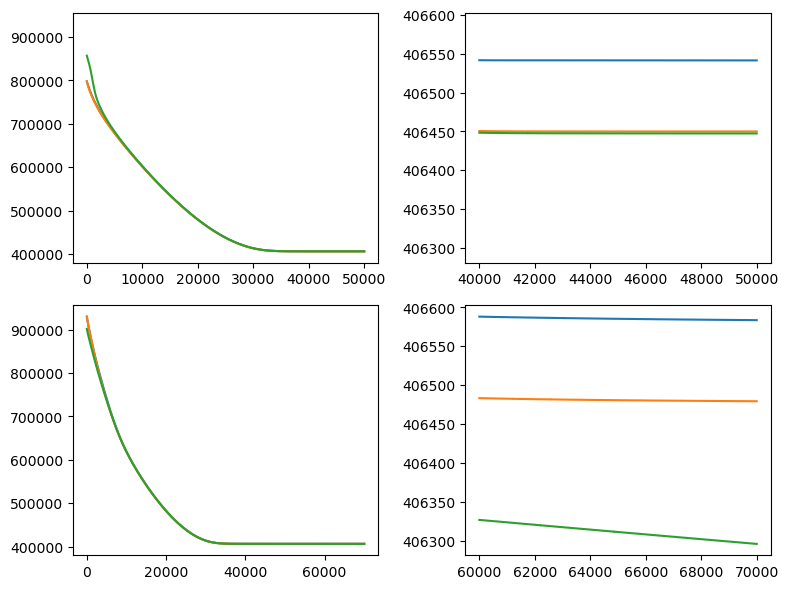

In [17]:
fig, axs = plt.subplots(2,2, figsize=(8,6), sharex=False, sharey='col')

for name, model in zip(['Pooled', 'Unpooled', 'Partial'], [wykoff_pooled, wykoff_unpooled, wykoff_partial]):
    axs[0,0].plot(np.arange(len(model.losses)), model.losses, label=name)
    axs[0,1].plot(np.arange(len(model.losses))[-10000:], model.losses[-10000:])
for name, model in zip(['Pooled', 'Unpooled', 'Partial'], [potmod_pooled, potmod_unpooled, potmod_partial]):
    axs[1,0].plot(np.arange(len(model.losses)), model.losses, label=name)
    axs[1,1].plot(np.arange(len(model.losses))[-10000:], model.losses[-10000:])

plt.tight_layout()
plt.show()

In [18]:
wykoff_config = {f"b{i}z": LocScaleReparam(centered=0) for i in range(9)}
        
wykoff_pooled_pred = Predictive(
    model=numpyro.handlers.reparam(wykoff, config=wykoff_config), 
    guide=autoguide.AutoDelta(numpyro.handlers.reparam(wykoff, config=wykoff_config)),
    params=wykoff_pooled.params,
    num_samples=10
)

wykoff_unpooled_pred = Predictive(
    model=numpyro.handlers.reparam(wykoff, config=wykoff_config), 
    guide=autoguide.AutoDelta(numpyro.handlers.reparam(wykoff, config=wykoff_config)),
    params=wykoff_unpooled.params,
    num_samples=10
)

wykoff_partial_pred = Predictive(
    model=numpyro.handlers.reparam(wykoff, config=wykoff_config), 
    guide=autoguide.AutoDelta(numpyro.handlers.reparam(wykoff, config=wykoff_config)),
    params=wykoff_partial.params,
    num_samples=10
)

In [19]:
potmod_config = {f"b{i}z": LocScaleReparam(centered=0) for i in range(3)}
        
potmod_pooled_pred = Predictive(
    model=numpyro.handlers.reparam(potential_modified, config=potmod_config), 
    guide=autoguide.AutoDelta(numpyro.handlers.reparam(potential_modified, config=potmod_config)),
    params=potmod_pooled.params,
    num_samples=10
)

potmod_unpooled_pred = Predictive(
    model=numpyro.handlers.reparam(potential_modified, config=potmod_config), 
    guide=autoguide.AutoDelta(numpyro.handlers.reparam(potential_modified, config=potmod_config)),
    params=potmod_unpooled.params,
    num_samples=10
)

potmod_partial_pred = Predictive(
    model=numpyro.handlers.reparam(potential_modified, config=potmod_config), 
    guide=autoguide.AutoDelta(numpyro.handlers.reparam(potential_modified, config=potmod_config)),
    params=potmod_partial.params,
    num_samples=10
)

In [20]:
sorted_data = data.sort_values(by=['BAI_OBS'])                   

wykoff_pooled_preds = wykoff_pooled_pred(
    random.PRNGKey(1),
    X=[sorted_data[col].values for col in MODEL_COVARS],
    pooling='pooled',
    y=sorted_data['BAI_OBS'].values,
)

wykoff_unpooled_preds = wykoff_unpooled_pred(
    random.PRNGKey(1),
    X=[sorted_data[col].values for col in MODEL_COVARS],
    pooling='unpooled',
    y=sorted_data['BAI_OBS'].values,
)

wykoff_partial_preds = wykoff_partial_pred(
    random.PRNGKey(1),
    X=[sorted_data[col].values for col in MODEL_COVARS],
    pooling='partial',
    y=sorted_data['BAI_OBS'].values,
)

potmod_pooled_preds = potmod_pooled_pred(
    random.PRNGKey(1),
    X=[sorted_data[col].values for col in MODEL_COVARS],
    pooling='pooled',
    y=sorted_data['BAI_OBS'].values,
)

potmod_unpooled_preds = potmod_unpooled_pred(
    random.PRNGKey(1),
    X=[sorted_data[col].values for col in MODEL_COVARS],
    pooling='unpooled',
    y=sorted_data['BAI_OBS'].values,
)

potmod_partial_preds = potmod_partial_pred(
    random.PRNGKey(1),
    X=[sorted_data[col].values for col in MODEL_COVARS],
    pooling='partial',
    y=sorted_data['BAI_OBS'].values,
)

In [21]:
pred_grid = [
    [wykoff_pooled_preds, wykoff_unpooled_preds, wykoff_partial_preds],
    [potmod_pooled_preds, potmod_unpooled_preds, potmod_partial_preds]
]

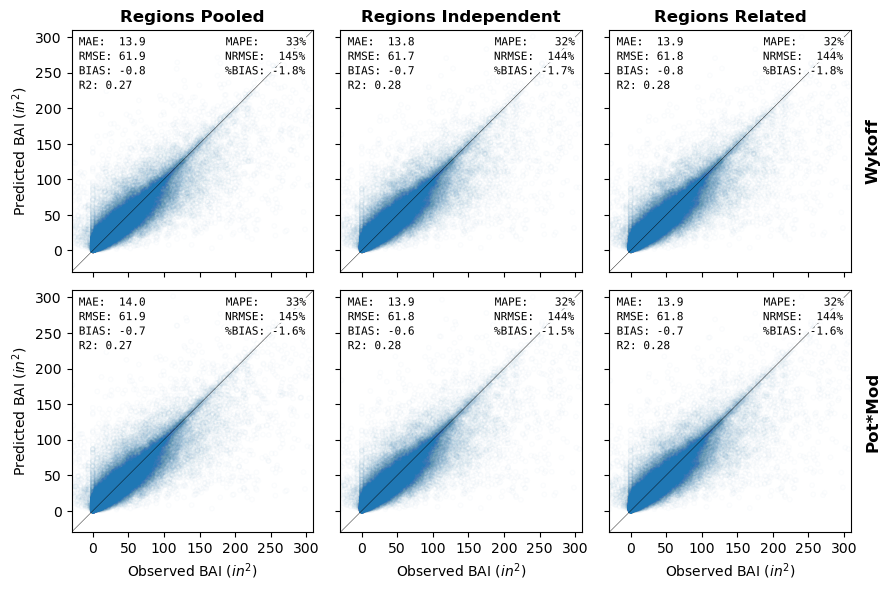

In [22]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=True, figsize=(9,6))
for i in range(2):
    for j in range(3):
        axs[i,j].scatter(sorted_data['BAI_OBS'].values, pred_grid[i][j]['bai_pred'].mean(axis=0), facecolor='none', edgecolor='tab:blue', s=10.0, alpha=0.02)
        r2, bias = pred_grid[i][j]['bai_r2'].mean(axis=0), pred_grid[i][j]['bai_bias'].mean(axis=0)
        mae, rmse = pred_grid[i][j]['bai_mae'].mean(axis=0), pred_grid[i][j]['bai_rmse'].mean(axis=0)
        mape, nrmse, pct_bias = mae/data['BAI_OBS'].mean(), rmse/data['BAI_OBS'].mean(), bias/data['BAI_OBS'].mean()
        font_params = dict(fontsize=8, font='monospace', va='top', path_effects=[pe.withStroke(linewidth=4, foreground='white')])
        axs[i,j].text(0.03, 0.97, f'MAE:  {mae:.1f}', transform=axs[i,j].transAxes, ha='left', **font_params)
        axs[i,j].text(0.973, 0.97, f'MAPE:    {mape:.0%}', transform=axs[i,j].transAxes, ha='right', **font_params)
        axs[i,j].text(0.03, 0.91, f'RMSE: {rmse:.1f}', transform=axs[i,j].transAxes, ha='left', **font_params)
        axs[i,j].text(0.97, 0.91, f'NRMSE:  {nrmse:.0%}', transform=axs[i,j].transAxes, ha='right', **font_params)
        axs[i,j].text(0.03, 0.85, f'BIAS: {bias:.1f}', transform=axs[i,j].transAxes, ha='left', **font_params)
        axs[i,j].text(0.97, 0.85, f'%BIAS: {pct_bias:.1%}', transform=axs[i,j].transAxes, ha='right', **font_params)
        axs[i,j].text(0.03, 0.79, f'R2: {r2:.2f}', transform=axs[i,j].transAxes, ha='left', **font_params)

for ax in axs.ravel():
    ax.plot([-30,310], [-30,310], color='black', lw=0.3)
    ax.set(
        ylim=(-30,310), xlim=(-30,310), 
        xticks=np.arange(0,350,50), yticks=np.arange(0,350,50),
        aspect='equal', 
    )
for ax in axs[-1,:]:
    ax.set(xlabel='Observed BAI ($in^{2}$)')
for ax in axs[:,0]:
    ax.set(ylabel='Predicted BAI ($in^{2}$)')
axs[0,-1].set_ylabel('Wykoff', rotation=90, labelpad=10, fontsize=12, fontweight='bold')
axs[1,-1].set_ylabel('Pot*Mod', rotation=90, labelpad=10, fontsize=12, fontweight='bold')
for ax in axs[:,-1]:
    ax.yaxis.set_label_position("right")
    
axs[0,0].set_title('Regions Pooled', fontsize=12, fontweight='bold')
axs[0,1].set_title('Regions Independent', fontsize=12, fontweight='bold')
axs[0,2].set_title('Regions Related', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/figures/BAIFit_PredictedvsObserved-BAI.png', dpi=300, bbox_inches='tight')
plt.show()

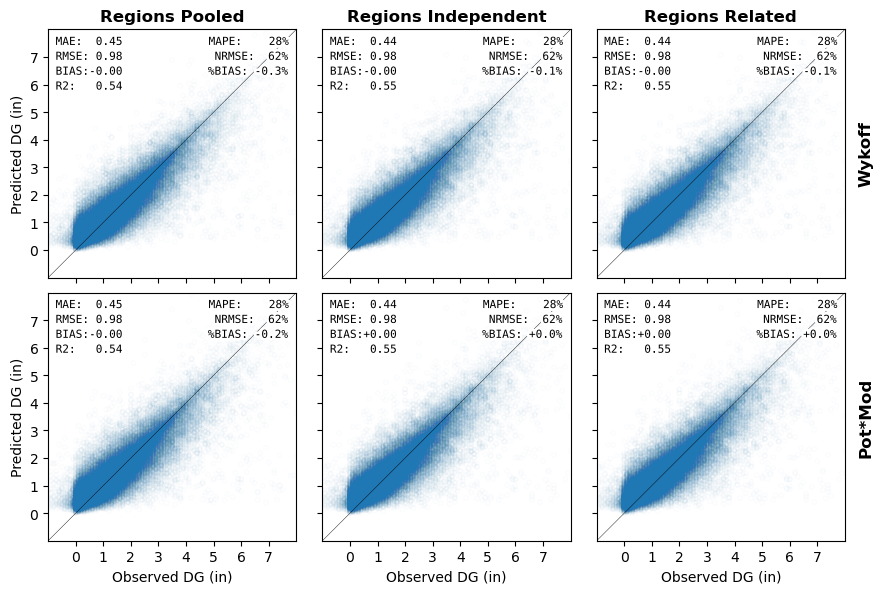

In [23]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=True, figsize=(9,6))
for i in range(2):
    for j in range(3):
        axs[i,j].scatter(sorted_data['DG_OBS'].values, pred_grid[i][j]['dg_pred'].mean(axis=0), facecolor='none', edgecolor='tab:blue', s=10.0, alpha=0.02)
        r2, bias = pred_grid[i][j]['dg_r2'].mean(axis=0), pred_grid[i][j]['dg_bias'].mean(axis=0)
        mae, rmse = pred_grid[i][j]['dg_mae'].mean(axis=0), pred_grid[i][j]['dg_rmse'].mean(axis=0)
        mape, nrmse, pct_bias = mae/data['DG_OBS'].mean(), rmse/data['DG_OBS'].mean(), bias/data['DG_OBS'].mean()
        font_params = dict(fontsize=8, font='monospace', va='top', path_effects=[pe.withStroke(linewidth=4, foreground='white')])
        axs[i,j].text(0.03, 0.97, f'MAE:  {mae:.2f}', transform=axs[i,j].transAxes, ha='left', **font_params)
        axs[i,j].text(0.973, 0.97, f'MAPE:    {mape:.0%}', transform=axs[i,j].transAxes, ha='right', **font_params)
        axs[i,j].text(0.03, 0.91, f'RMSE: {rmse:.2f}', transform=axs[i,j].transAxes, ha='left', **font_params)
        axs[i,j].text(0.97, 0.91, f'NRMSE:  {nrmse:.0%}', transform=axs[i,j].transAxes, ha='right', **font_params)
        axs[i,j].text(0.03, 0.85, f'BIAS:{bias:+.2f}', transform=axs[i,j].transAxes, ha='left', **font_params)
        axs[i,j].text(0.97, 0.85, f'%BIAS: {pct_bias:+.1%}', transform=axs[i,j].transAxes, ha='right', **font_params)
        axs[i,j].text(0.03, 0.79, f'R2:   {r2:.2f}', transform=axs[i,j].transAxes, ha='left', **font_params)

for ax in axs.ravel():
    ax.plot([-1,20], [-1,20], color='black', lw=0.3)
    ax.set(
        ylim=(-1,8), xlim=(-1,8), 
        xticks=np.arange(0,8), yticks=np.arange(0,8),
        aspect='equal', 
    )
for ax in axs[-1,:]:
    ax.set(xlabel='Observed DG (in)')
for ax in axs[:,0]:
    ax.set(ylabel='Predicted DG (in)')
axs[0,-1].set_ylabel('Wykoff', rotation=90, labelpad=10, fontsize=12, fontweight='bold')
axs[1,-1].set_ylabel('Pot*Mod', rotation=90, labelpad=10, fontsize=12, fontweight='bold')
for ax in axs[:,-1]:
    ax.yaxis.set_label_position("right")
    
axs[0,0].set_title('Regions Pooled', fontsize=12, fontweight='bold')
axs[0,1].set_title('Regions Independent', fontsize=12, fontweight='bold')
axs[0,2].set_title('Regions Related', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/figures/BAIFit_PredictedvsObserved-DG.png', dpi=300, bbox_inches='tight')
plt.show()

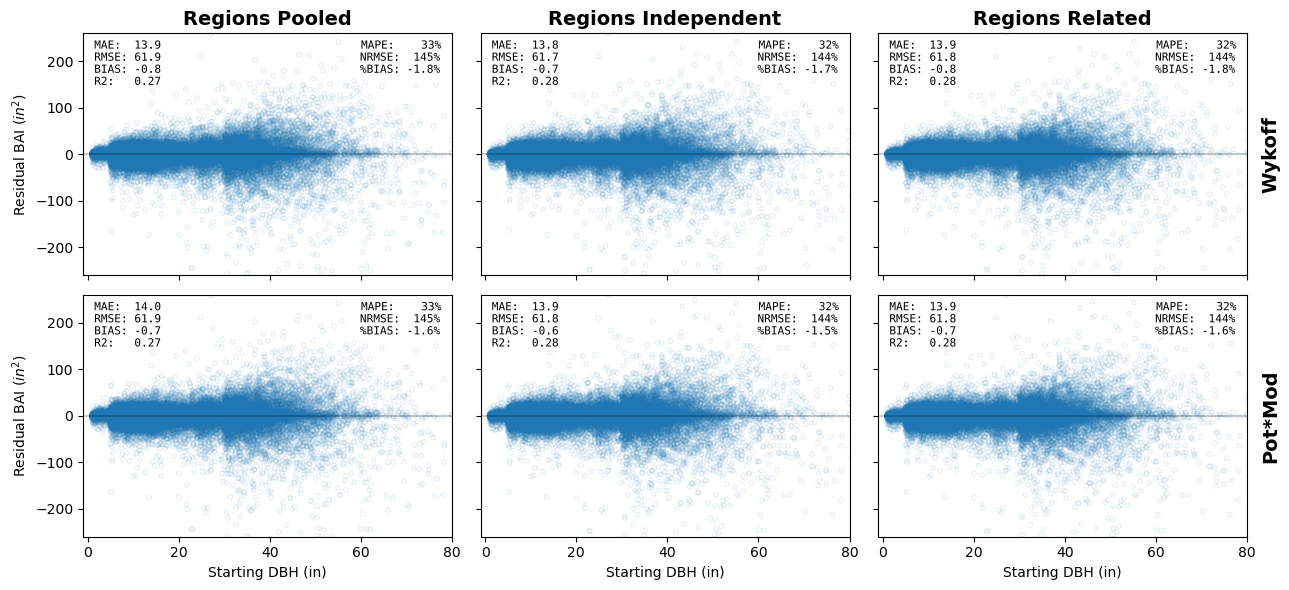

In [24]:
fig, axs = plt.subplots(2,3, figsize=(13,6), sharex=True, sharey=True)
for i in range(2):
    for j in range(3):
        axs[i,j].scatter(sorted_data['DBH'],  pred_grid[i][j]['bai_resid'].mean(axis=0), s=10.0, facecolor='none', edgecolor='tab:blue', alpha=0.10)
        r2, bias = pred_grid[i][j]['bai_r2'].mean(axis=0), pred_grid[i][j]['bai_bias'].mean(axis=0)
        mae, rmse = pred_grid[i][j]['bai_mae'].mean(axis=0), pred_grid[i][j]['bai_rmse'].mean(axis=0)
        mape, nrmse, pct_bias = mae/data['BAI_OBS'].mean(), rmse/data['BAI_OBS'].mean(), bias/data['BAI_OBS'].mean()
        font_params = dict(fontsize=8, font='monospace', va='top', path_effects=[pe.withStroke(linewidth=4, foreground='white')])
        axs[i,j].text(0.03, 0.97, f'MAE:  {mae:.1f}', transform=axs[i,j].transAxes, ha='left', **font_params)
        axs[i,j].text(0.973, 0.97, f'MAPE:    {mape:.0%}', transform=axs[i,j].transAxes, ha='right', **font_params)
        axs[i,j].text(0.03, 0.92, f'RMSE: {rmse:.1f}', transform=axs[i,j].transAxes, ha='left', **font_params)
        axs[i,j].text(0.97, 0.92, f'NRMSE:  {nrmse:.0%}', transform=axs[i,j].transAxes, ha='right', **font_params)
        axs[i,j].text(0.03, 0.87, f'BIAS: {bias:+.1f}', transform=axs[i,j].transAxes, ha='left', **font_params)
        axs[i,j].text(0.97, 0.87, f'%BIAS: {pct_bias:+.1%}', transform=axs[i,j].transAxes, ha='right', **font_params)
        axs[i,j].text(0.03, 0.82, f'R2:   {r2:.2f}', transform=axs[i,j].transAxes, ha='left', **font_params)

for ax in axs.ravel():
    ax.set(xlim=(-1,80), ylim=(-260,260))
    ax.axhline(0, lw=0.3, color='black')

axs[0,0].set_title('Regions Pooled', fontsize=14, fontweight='bold')
axs[0,1].set_title('Regions Independent', fontsize=14, fontweight='bold')
axs[0,2].set_title('Regions Related', fontsize=14, fontweight='bold')

for ax in axs[:,0]:
    ax.set(ylabel='Residual BAI ($in^{2}$)')
axs[0,-1].set_ylabel('Wykoff', rotation=90, labelpad=10, fontsize=14, fontweight='bold')
axs[1,-1].set_ylabel('Pot*Mod', rotation=90, labelpad=10, fontsize=14, fontweight='bold')
for ax in axs[:,-1]:
    ax.yaxis.set_label_position("right")
for ax in axs[-1,:]:
    ax.set(xlabel='Starting DBH (in)')
plt.tight_layout()
plt.savefig('../reports/figures/BAIFit_ResidualsvsDBH-BAI.png', dpi=300, bbox_inches='tight')
plt.show()

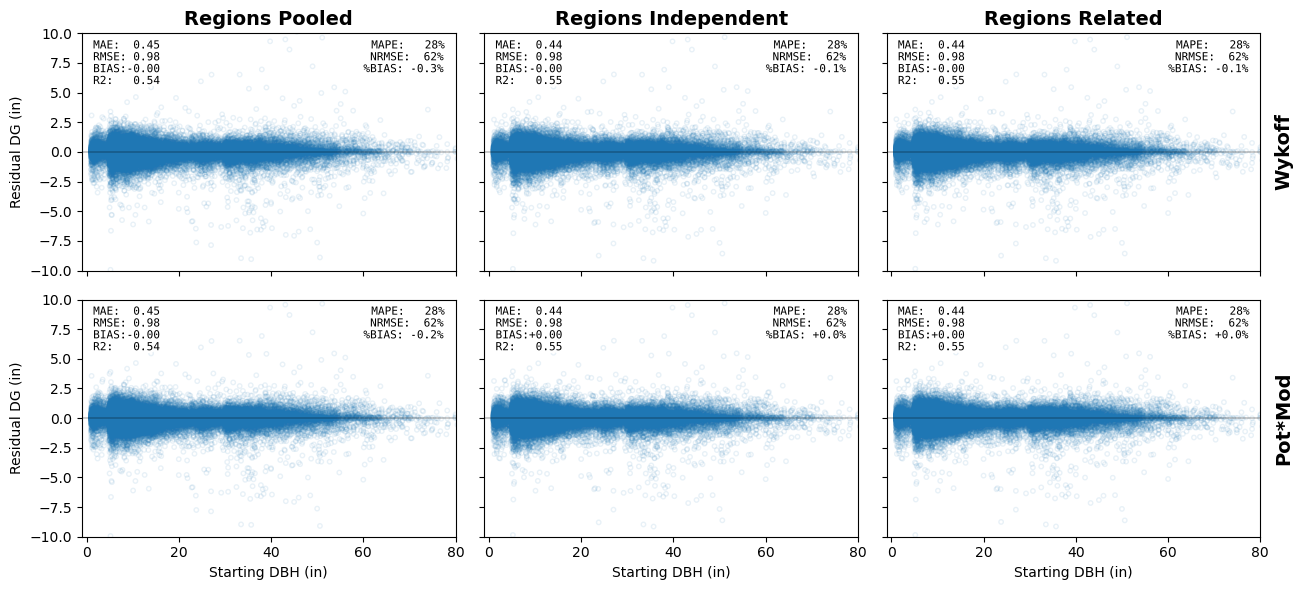

In [25]:
fig, axs = plt.subplots(2,3, figsize=(13,6), sharex=True, sharey=True)
for i in range(2):
    for j in range(3):
        axs[i,j].scatter(sorted_data['DBH'],  pred_grid[i][j]['dg_resid'].mean(axis=0), s=10.0, facecolor='none', edgecolor='tab:blue', alpha=0.10)
        r2, bias = pred_grid[i][j]['dg_r2'].mean(axis=0), pred_grid[i][j]['dg_bias'].mean(axis=0)
        mae, rmse = pred_grid[i][j]['dg_mae'].mean(axis=0), pred_grid[i][j]['dg_rmse'].mean(axis=0)
        mape, nrmse, pct_bias = mae/data['DG_OBS'].mean(), rmse/data['DG_OBS'].mean(), bias/data['DG_OBS'].mean()
        font_params = dict(fontsize=8, font='monospace', va='top', path_effects=[pe.withStroke(linewidth=4, foreground='white')])
        axs[i,j].text(0.03, 0.97, f'MAE:  {mae:.2f}', transform=axs[i,j].transAxes, ha='left', **font_params)
        axs[i,j].text(0.973, 0.97, f'MAPE:   {mape:.0%}', transform=axs[i,j].transAxes, ha='right', **font_params)
        axs[i,j].text(0.03, 0.92, f'RMSE: {rmse:.2f}', transform=axs[i,j].transAxes, ha='left', **font_params)
        axs[i,j].text(0.97, 0.92, f'NRMSE:  {nrmse:.0%}', transform=axs[i,j].transAxes, ha='right', **font_params)
        axs[i,j].text(0.03, 0.87, f'BIAS:{bias:+.2f}', transform=axs[i,j].transAxes, ha='left', **font_params)
        axs[i,j].text(0.97, 0.87, f'%BIAS: {pct_bias:+.1%}', transform=axs[i,j].transAxes, ha='right', **font_params)
        axs[i,j].text(0.03, 0.82, f'R2:   {r2:.2f}', transform=axs[i,j].transAxes, ha='left', **font_params)

for ax in axs.ravel():
    ax.set(xlim=(-1,80), ylim=(-10,10))
    ax.axhline(0, lw=0.3, color='black')

axs[0,0].set_title('Regions Pooled', fontsize=14, fontweight='bold')
axs[0,1].set_title('Regions Independent', fontsize=14, fontweight='bold')
axs[0,2].set_title('Regions Related', fontsize=14, fontweight='bold')

for ax in axs[:,0]:
    ax.set(ylabel='Residual DG (in)')
axs[0,-1].set_ylabel('Wykoff', rotation=90, labelpad=10, fontsize=14, fontweight='bold')
axs[1,-1].set_ylabel('Pot*Mod', rotation=90, labelpad=10, fontsize=14, fontweight='bold')
for ax in axs[:,-1]:
    ax.yaxis.set_label_position("right")
for ax in axs[-1,:]:
    ax.set(xlabel='Starting DBH (in)')
plt.tight_layout()
plt.savefig('../reports/figures/BAIFit_ResidualsvsDBH-DG.png', dpi=300, bbox_inches='tight')
plt.show()

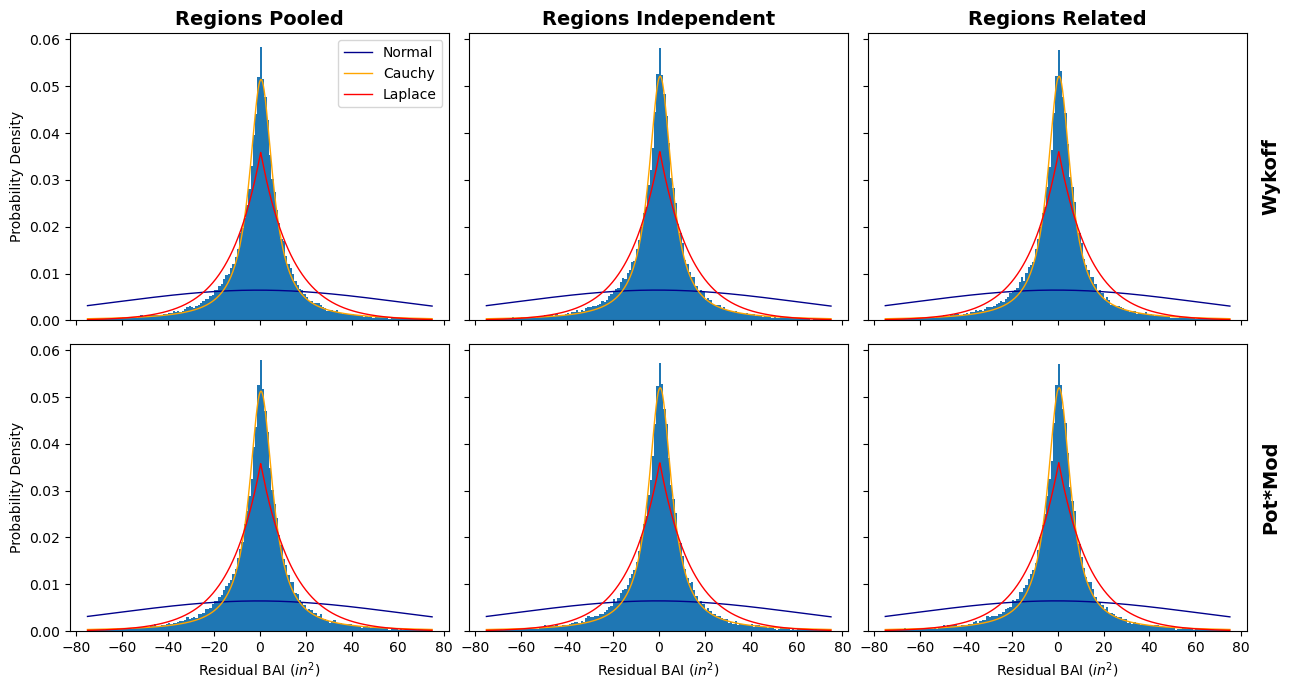

In [26]:
param_grid = [
    [wykoff_pooled, wykoff_unpooled, wykoff_partial],
    [potmod_pooled, potmod_unpooled, potmod_partial]
]

fig, axs = plt.subplots(2,3, figsize=(13,7), sharex=True, sharey=True)
for i in range(2):
    for j in range(3):
        xmin, xmax = -75, 75
        xs = np.linspace(xmin, xmax, 1000)
        resid = pred_grid[i][j]['bai_resid'].mean(axis=0)
        axs[i,j].hist(resid, bins=np.arange(xmin,xmax), density=True)
        axs[i,j].plot(xs, stats.norm(*stats.norm.fit(resid)).pdf(xs), lw=1.0, label='Normal', color='darkblue')
        axs[i,j].plot(xs, stats.cauchy(*stats.cauchy.fit(resid)).pdf(xs), lw=1.0, label='Cauchy', color='orange')
        axs[i,j].plot(xs, stats.laplace(*stats.laplace.fit(resid)).pdf(xs), lw=1.0, label='Laplace', color='red')

axs[0,0].set_title('Regions Pooled', fontsize=14, fontweight='bold')
axs[0,1].set_title('Regions Independent', fontsize=14, fontweight='bold')
axs[0,2].set_title('Regions Related', fontsize=14, fontweight='bold')
axs[0,0].legend()

for ax in axs[:,0]:
    ax.set(ylabel='Probability Density')
    
axs[0,-1].set_ylabel('Wykoff', rotation=90, labelpad=10, fontsize=14, fontweight='bold')
axs[1,-1].set_ylabel('Pot*Mod', rotation=90, labelpad=10, fontsize=14, fontweight='bold')
for ax in axs[:,-1]:
    ax.yaxis.set_label_position("right")
for ax in axs[-1,:]:
    ax.set(xlabel='Residual BAI ($in^{2}$)')
plt.tight_layout()
plt.savefig('../reports/figures/BAIFit_ResidualsDistribution-BAI.png', dpi=300, bbox_inches='tight')
plt.show()

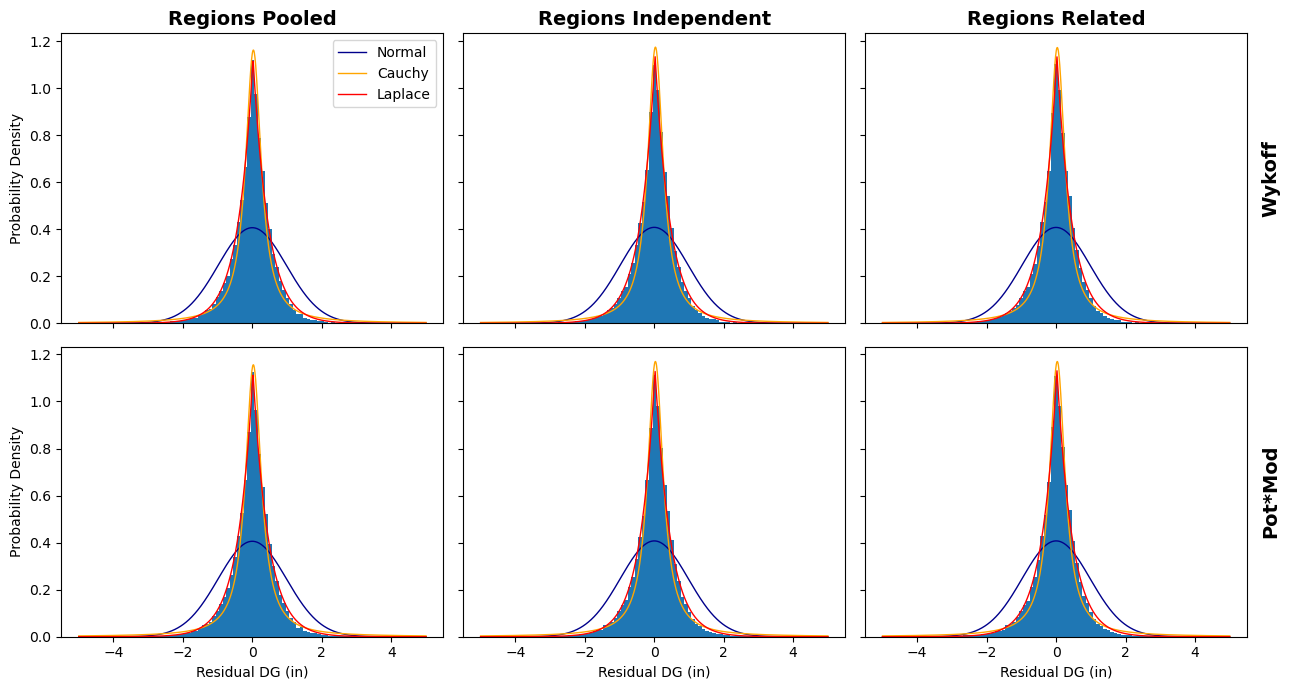

In [27]:
param_grid = [
    [wykoff_pooled, wykoff_unpooled, wykoff_partial],
    [potmod_pooled, potmod_unpooled, potmod_partial]
]

fig, axs = plt.subplots(2,3, figsize=(13,7), sharex=True, sharey=True)
for i in range(2):
    for j in range(3):
        xmin, xmax = -5, 5
        xs = np.linspace(xmin, xmax, 1000)
        resid = pred_grid[i][j]['dg_resid'].mean(axis=0)
        axs[i,j].hist(resid, bins=np.linspace(xmin,xmax,100), density=True)
        axs[i,j].plot(xs, stats.norm(*stats.norm.fit(resid)).pdf(xs), lw=1.0, label='Normal', color='darkblue')
        axs[i,j].plot(xs, stats.cauchy(*stats.cauchy.fit(resid)).pdf(xs), lw=1.0, label='Cauchy', color='orange')
        axs[i,j].plot(xs, stats.laplace(*stats.laplace.fit(resid)).pdf(xs), lw=1.0, label='Laplace', color='red')

axs[0,0].set_title('Regions Pooled', fontsize=14, fontweight='bold')
axs[0,1].set_title('Regions Independent', fontsize=14, fontweight='bold')
axs[0,2].set_title('Regions Related', fontsize=14, fontweight='bold')
axs[0,0].legend()

for ax in axs[:,0]:
    ax.set(ylabel='Probability Density')
    
axs[0,-1].set_ylabel('Wykoff', rotation=90, labelpad=10, fontsize=14, fontweight='bold')
axs[1,-1].set_ylabel('Pot*Mod', rotation=90, labelpad=10, fontsize=14, fontweight='bold')
for ax in axs[:,-1]:
    ax.yaxis.set_label_position("right")
for ax in axs[-1,:]:
    ax.set(xlabel='Residual DG (in)')
plt.tight_layout()
plt.savefig('../reports/figures/BAIFit_ResidualsDistribution-DG.png', dpi=300, bbox_inches='tight')
plt.show()